# Importing the required Libraries


In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import sys
import math

# Bilinear interpolation Function
Here we are creating a bilinear interpolation function so that we can use it for target to source mapping.

In [ ]:
def bilinear_interpolate(zero_padded_image, x, y):
    
    xx, yy = np.shape(zero_padded_image)# shape of the zero padded image
    xx, yy = xx-2, yy-2                 # get the shape of the original image
    x, y = x+1, y+1                     # +1 as we are taking coordinates with respect to a zero padded image

    x_prime, y_prime= math.floor(x),math.floor(y)# x', y', a, b as defined in the lecture
    
    a = x-x_prime
    b = y-y_prime

    if x_prime >= 0 and x_prime <= xx and y_prime >= 0 and y_prime <= yy:
        # intensity value using bilinear interpolation
        intensity_value = (1-a)*(1-b)*zero_padded_image[x_prime, y_prime] + (1-a)*b*zero_padded_image[x_prime, y_prime+1] \
        + a*(1-b)*zero_padded_image[x_prime+1, y_prime] + a*b*zero_padded_image[x_prime+1, y_prime+1]
    else:
        # If the (xs, ys) does not exist in the source image, assign 0 for the corresponding (xt, yt) in the target image
        intensity_value = 0

    return intensity_value

# Creating A matrix
We know that the equation for homography matrix can be solved by Ah=0. Since the images are related by in plane rotation and translation it will have 4 unknowns. As we know each point correspondence gives 2 equations and hence 2 point correspondences as given in the question are enough to solve for the homography matrix.

So, Now, by using the given point corespondences, we form A matrix.

In [ ]:
A=np.zeros((4,5))              #Homography from image2 to image1.
(x1,y1)=(93, 248)              #Let, (x1,y1) points in image2 corresponds to (x1_prime, y1_prime) points in image1.
(x1_prime,y1_prime)=(29, 124)  #Similar is followed by second point (x2,y2) also.
(x2,y2)=(328, 399)
(x2_prime,y2_prime)=(157, 372)
A[0]=[x1,y1,1,0,-x1_prime]     #Row of A is of format:
A[1]=[y1,-x1,0,1,-y1_prime]    #For one point, we get 2 equations. i.e. 2 rows of A which are:
A[2]=[x2,y2,1,0,-x2_prime]     #A 1st row=[x1,y1,1,0,x1_prime]
A[3]=[y2,-x2,0,1,-y2_prime]    #A 2nd row=[y1,-x1,0,1,-y1_prime]

# Calculating H matrix

In [ ]:
# Here we are calculating the distinct values that are there in H matrix. 
# i.e. We are actually calculating the values of h array whch will, then, be used to construct complete H matrix

# NumPy SVD gives singular values in decreasing order
u, s, v_transpose = np.linalg.svd(A)
# take the last row of v_transpose
a, b, c, d, h = v_transpose[-1]

# construct the complete 3x3 H matrix
H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)

#Reading the images

In [ ]:
image1 = imageio.imread("IMG1.png")
image2 = imageio.imread("IMG2.png")

#Tranforming the image
Using the calculated Homography matrix H and by using blinear interpolation for target to source mapping we now proceed to transform Image 2 to align with the Image 1.

In [ ]:
# zero padding the image for bilinear interpolation
x, y = np.shape(image2)
image = np.zeros((x+2, y+2))
image[1:-1, 1:-1] = image2
# Computing inverse of H to map target coordinates[image1] to source coordinates[image2]
H_inv = np.linalg.inv(H)

transformed_image = np.zeros((x, y))

for xt in range(x):
  for yt in range(y):
   # converting to homogenous coordinates
    vec = np.array([xt, yt, 1])
            # calculate the corresponding points for
            # (xt, yt) in the source image
    x_prime = H_inv@vec
    if x_prime[-1]!=0:
      (xs,ys)=(x_prime[0]/x_prime[-1], x_prime[1]/x_prime[-1])
    else:
      (xs,ys)=(0,0)  
    
            # Assign the value using bilinear interpolation
    val = bilinear_interpolate(image, xs, ys)
    transformed_image[xt, yt] = val

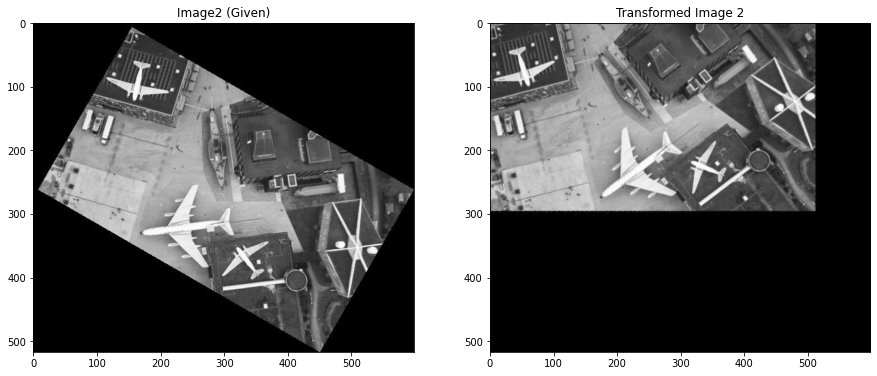

In [ ]:
#Plotting the Transformed Image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,18))

ax1.imshow(image2, 'gray')
ax2.imshow(transformed_image, 'gray')

ax1.title.set_text("Image2 (Given)")
ax2.title.set_text("Transformed Image 2")
plt.show()

Text(0.5, 1.0, 'Image1 (Given)')

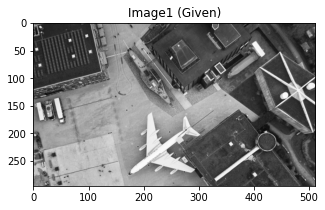

In [ ]:
#Plotting image1
plt.imshow(image1,'gray')
plt.title("Image1 (Given)")

Cropping the Transformed Image2 to be of same size as of Image 1 so as to use it for Change Detection.

In [ ]:
(q,w)= np.shape(image1)
transformed_img_cropped=transformed_image[:q,:w]
change=transformed_img_cropped-image1

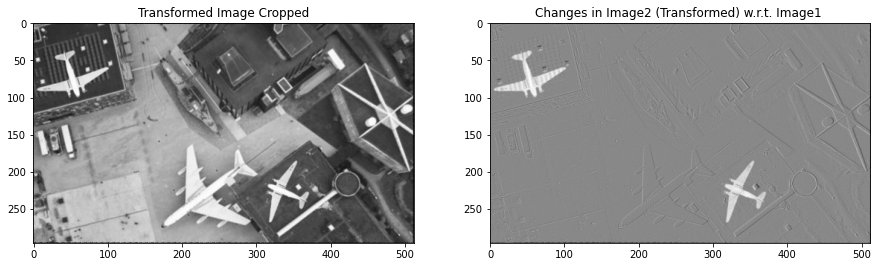

In [ ]:
#Plotting the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,18))

ax1.imshow(transformed_img_cropped, 'gray')
ax2.imshow(change, 'gray')

ax1.title.set_text("Transformed Image Cropped")
ax2.title.set_text("Changes in Image2 (Transformed) w.r.t. Image1 ")
plt.show()

# Finding
As seen from the above plotted image, We find that there are 2 aeroplanes present in the image 2 which were absent in image1.

This was possible as we had exact point correspondences given in the question.